#Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchaudio
import torchaudio.transforms as transforms
import tensorflow as tf
import librosa
import pandas as pd
import time
import random
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Creating dataset using 10 clips with 3s for each song 


In [3]:
def extract_segment_features(y, sr, start_sample, end_sample):
    segment = y[start_sample:end_sample]

    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)

    spectral_contrast = librosa.feature.spectral_contrast(y=segment, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast.T, axis=0)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(segment)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate.T, axis=0)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
    spectral_rolloff_mean = np.mean(spectral_rolloff.T, axis=0)

    rmse = librosa.feature.rms(y=segment)
    rmse_mean = np.mean(rmse.T, axis=0)

    tempo, _ = librosa.beat.beat_track(y=segment, sr=sr)

    features = np.hstack([mfccs_mean, chroma_mean, spectral_contrast_mean,
                          zero_crossing_rate_mean, spectral_rolloff_mean,
                          rmse_mean, tempo])
    return features

def extract_features(file_name):
    y, sr = librosa.load(file_name, sr=44100)

    duration = len(y)
    segment_length = 3 * sr

    middle = (duration // 2) - 10*3*sr

    features_list = []
    for i in range(20):
        start_sample = middle
        end_sample = start_sample + segment_length
        segment_features = extract_segment_features(y, sr, start_sample, end_sample)
        features_list.append(segment_features)
        middle = end_sample + 1

    return features_list

genres = {
    'Rock': 'drive/MyDrive/MusicGenreDatasetAudio/Rock/',
    'Zabavna': 'drive/MyDrive/MusicGenreDatasetAudio/Zabavna/',
    'Narodna': 'drive/MyDrive/MusicGenreDatasetAudio/Narodna/',
    'Sevdah': 'drive/MyDrive/MusicGenreDatasetAudio/Sevdah/',
    'HipHop': 'drive/MyDrive/MusicGenreDatasetAudio/HipHop/'
}

train_features_list = []
test_features_list = []

random.seed(42)

for genre, dir_path in genres.items():
    audio_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.mp3')]

    random.shuffle(audio_files)

    train_files = audio_files[:24]
    test_files = audio_files[24:]

    for file in train_files:
      segments_features = extract_features(file)
      for features in segments_features:
          train_features_list.append([genre] + features.tolist())

    for file in test_files:
      segments_features = extract_features(file)
      for features in segments_features:
        test_features_list.append([genre] + features.tolist())

column_names = ['class'] + \
               [f'mfcc_{i}' for i in range(1, 21)] + \
               [f'chroma_{i}' for i in range(1, 13)] + \
               [f'spectral_contrast_{i}' for i in range(1, 8)] + \
               ['zero_crossing_rate', 'spectral_rolloff', 'rmse', 'tempo']

train_df = pd.DataFrame(train_features_list, columns=column_names)
test_df = pd.DataFrame(test_features_list, columns=column_names)

train_df.to_csv('audio_features_train_10t3s.csv', index=False)
test_df.to_csv('audio_features_test_10t3s.csv', index=False)

##Correlation

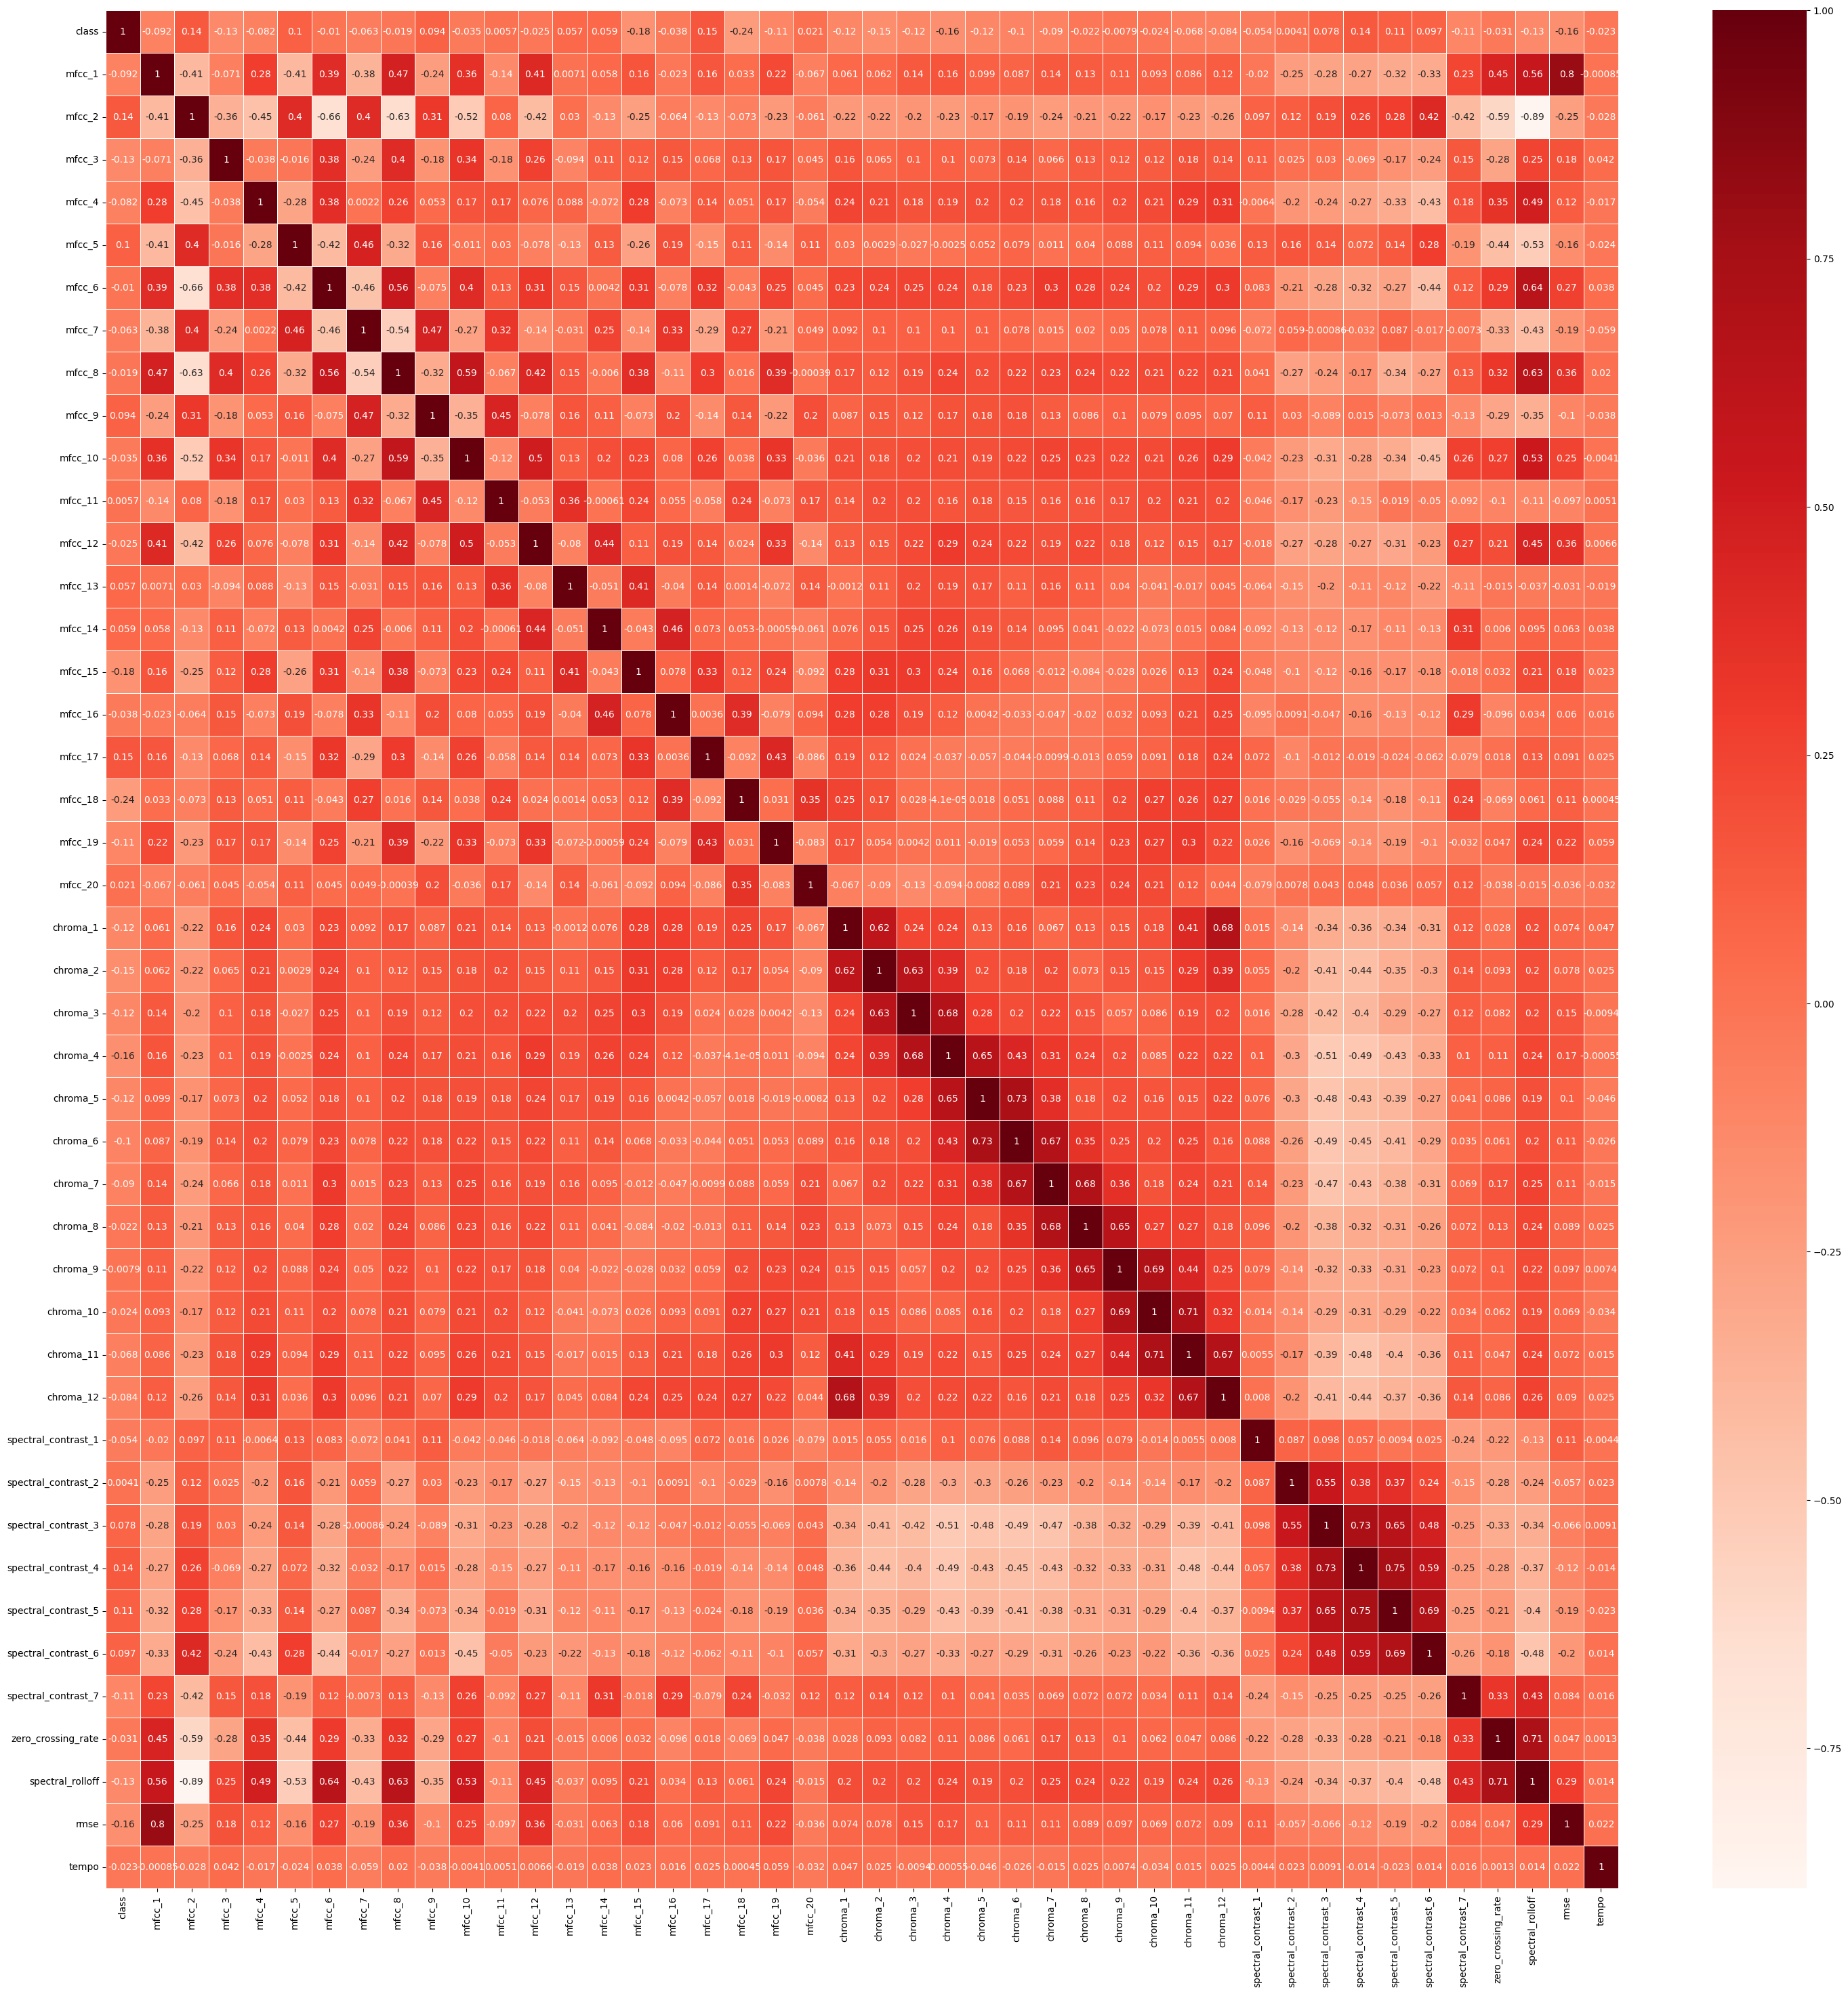

In [4]:
Label_encoder = LabelEncoder()
train_df["class"] = Label_encoder.fit_transform(train_df["class"])

plt.figure(figsize=(36,36))
cor = train_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, linewidths=0.5)
plt.show()

#Training on dataset

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

train_df = pd.read_csv('audio_features_train_10t3s.csv')
test_df = pd.read_csv('audio_features_test_10t3s.csv')

X_train = train_df.drop(columns=['class'])
y_train = train_df['class']
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

X_test = test_df.drop(columns=['class'])
y_test = test_df['class']
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)

min_max_scaler = MinMaxScaler()
X_test = min_max_scaler.fit_transform(X_test)

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

# Hyperparameter tuning
param_grid = {
    'KNN': {'n_neighbors': [3, 5, 10, 20, 50, 100]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, 20]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7, 10]}
}

trained_models = []

for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train_encoded)

    best_model = grid_search.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
    test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Training Accuracy: {train_accuracy:.2f}")
    print(f"{model_name} Test Accuracy: {test_accuracy:.2f}")
    print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))
    print("\n" + "-"*60 + "\n")

    trained_models.append((best_model, model_name))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


KNN Best Parameters: {'n_neighbors': 5}
KNN Training Accuracy: 0.97
KNN Test Accuracy: 0.42
              precision    recall  f1-score   support

      HipHop       0.31      0.31      0.31       120
     Narodna       0.36      0.47      0.41       120
        Rock       0.56      0.27      0.36       120
      Sevdah       0.66      0.84      0.74       120
     Zabavna       0.21      0.20      0.20       120

    accuracy                           0.42       600
   macro avg       0.42      0.42      0.41       600
weighted avg       0.42      0.42      0.41       600


------------------------------------------------------------

Random Forest Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Random Forest Training Accuracy: 0.99
Random Forest Test Accuracy: 0.47
              precision    recall  f1-score   support

      HipHop       0.36      0.12      0.18       120
     Narodna       0.45      0.66      0.54       120
        Rock       0.73      0.36      0.48       1

#Predict on new song


##Preprocessing song

In [9]:
def extract_segment_features(y, sr, start_sample, end_sample):
    segment = y[start_sample:end_sample]

    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)

    spectral_contrast = librosa.feature.spectral_contrast(y=segment, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast.T, axis=0)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(segment)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate.T, axis=0)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
    spectral_rolloff_mean = np.mean(spectral_rolloff.T, axis=0)

    rmse = librosa.feature.rms(y=segment)
    rmse_mean = np.mean(rmse.T, axis=0)

    tempo, _ = librosa.beat.beat_track(y=segment, sr=sr)

    features = np.hstack([mfccs_mean, chroma_mean, spectral_contrast_mean,
                          zero_crossing_rate_mean, spectral_rolloff_mean,
                          rmse_mean, tempo])
    return features

def extract_features(file_name):
    y, sr = librosa.load(file_name, sr=44100)

    duration = len(y)
    segment_length = 3 * sr

    middle = (duration // 2) - 10*3*sr

    features_list = []
    for i in range(20):
        start_sample = middle
        end_sample = start_sample + 3*sr
        segment_features = extract_segment_features(y, sr, start_sample, end_sample)
        features_list.append(segment_features)
        middle = start_sample + 3*sr + 1

    return features_list

features_list = []

new_path = '/content/Prljavo Kazaliste - Kise Jesenje.mp3'

segments_features = extract_features(new_path)
for features in segments_features:
    features_list.append(['Rock'] + features.tolist())

column_names = ['class'] + \
               [f'mfcc_{i}' for i in range(1, 21)] + \
               [f'chroma_{i}' for i in range(1, 13)] + \
               [f'spectral_contrast_{i}' for i in range(1, 8)] + \
               ['zero_crossing_rate', 'spectral_rolloff', 'rmse', 'tempo']

new_df = pd.DataFrame(features_list, columns=column_names)

##Predict on "Prljavo Kazaliste - Kise Jesenje"

In [10]:
labels = ['HipHop', 'Narodna', 'Rock', 'Sevdah', 'Zabavna']

X_new = new_df.drop(columns=['class'])
y_new = new_df['class'].values

min_max_scaler = MinMaxScaler()
X_new = min_max_scaler.fit_transform(X_new)
for model, model_name in trained_models:
  predicts = [0, 0, 0, 0, 0]

  for i in range(len(X_new)):
      y_pred = model.predict([X_new[i]])
      predicts[y_pred[0]] += 1

  y_pred_fst = np.argmax(predicts)
  num_fst = predicts[y_pred_fst]
  predicts[y_pred_fst] = 0
  y_pred_snd = np.argmax(predicts)
  num_snd = predicts[y_pred_snd]

  print(f"{model_name} Model predicted: ",  labels[y_pred_fst], round(num_fst/20*100, 2), "%" , " or " , labels[y_pred_snd], round(num_snd/20*100,2), "%")
print("True label: ", labels[labels.index(y_new[0])])


KNN Model predicted:  HipHop 40.0 %  or  Sevdah 20.0 %
Random Forest Model predicted:  Rock 40.0 %  or  Sevdah 35.0 %
XGBoost Model predicted:  Sevdah 40.0 %  or  Rock 35.0 %
True label:  Rock


#Creating dataset of MEL spectrograms

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split

data_path = 'drive/MyDrive/MusicGenreDatasetAudio'

train_output_base = 'drive/MyDrive/MusicGenreDataset/Train'
test_output_base = 'drive/MyDrive/MusicGenreDataset/Test'

os.makedirs(train_output_base, exist_ok=True)
os.makedirs(test_output_base, exist_ok=True)

genre_files = {folder: [] for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))}
for folder in genre_files.keys():
    folder_path = os.path.join(data_path, folder)
    for audio in os.listdir(folder_path):
        if audio.endswith('.mp3'):
            audio_path = os.path.join(folder_path, audio)
            genre_files[folder].append(audio_path)

random.seed(42)

def generate_spectrograms(audio_files, output_base, genre, train=True):
    for audio_path in audio_files:
        waveform, sample_rate = librosa.load(audio_path, sr=44100)
        duration = len(waveform)
        segment_length = 3 * sample_rate

        middle = (duration // 2) - (10*3*sample_rate)

        for i in range(20):
            start_sample = middle
            end_sample = start_sample + segment_length
            segment_waveform = waveform[start_sample:end_sample]
            middle = end_sample + 1

            S = librosa.feature.melspectrogram(y=segment_waveform, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)

            plt.figure(figsize=(10, 4))
            librosa.display.specshow(S_dB, sr=sample_rate, hop_length=512, x_axis='time', y_axis='mel')
            plt.axis("off")

            split_type = 'train' if train else 'test'
            output_folder = os.path.join(output_base, genre)
            os.makedirs(output_folder, exist_ok=True)
            output_file = os.path.join(output_folder, f"{os.path.basename(audio_path)[:-4]}_{i+1}.png")
            plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
            plt.close()

for genre, files in genre_files.items():
    random.shuffle(files)

    train_files, test_files = train_test_split(files, test_size=6, train_size=24, random_state=42)

    generate_spectrograms(train_files, train_output_base, genre, train=True)

    generate_spectrograms(test_files, test_output_base, genre, train=False)

#CNN MODEL

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

CNNmodel = Sequential()

CNNmodel.add(Conv2D(16, (3, 3), input_shape = (128, 259, 3), activation='relu'))
CNNmodel.add(MaxPooling2D(pool_size = (2, 2)))
CNNmodel.add(Conv2D(32, (3, 3), activation='relu'))
CNNmodel.add(MaxPooling2D(pool_size = (2, 2)))
CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(MaxPooling2D(pool_size = (2, 2)))
CNNmodel.add(Conv2D(128, (3, 3), activation='relu'))
CNNmodel.add(MaxPooling2D(pool_size = (2, 2)))
CNNmodel.add(Flatten())

CNNmodel.add(Dense(units=512, activation='relu'))
CNNmodel.add(Dropout(0.2))

CNNmodel.add(Dense(units = 5, activation='softmax'))

CNNmodel.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_dataset = image_generator.flow_from_directory(batch_size=64,
                                                 directory='drive/MyDrive/MusicGenreDataset/train',
                                                 target_size=(128, 259),
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=64,
                                                 directory='drive/MyDrive/MusicGenreDataset/test',
                                                 target_size=(128, 259),
                                                 class_mode='categorical')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)

model_checkpoint = ModelCheckpoint('CNNbest_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

CNNmodel.fit(x=train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[early_stopping, model_checkpoint])



Found 2450 images belonging to 5 classes.
Found 650 images belonging to 5 classes.
Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 1.5095 - accuracy: 0.3404 
Epoch 1: val_loss improved from inf to 1.47462, saving model to CNNbest_model.h5
39/39 [==============================] - 723s 18s/step - loss: 1.5095 - accuracy: 0.3404 - val_loss: 1.4746 - val_accuracy: 0.3677
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - ETA: 0s - loss: 1.2731 - accuracy: 0.4567
Epoch 2: val_loss did not improve from 1.47462
39/39 [==============================] - 28s 726ms/step - loss: 1.2731 - accuracy: 0.4567 - val_loss: 1.4861 - val_accuracy: 0.3646
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 1.1055 - accuracy: 0.5380
Epoch 3: val_loss did not improve from 1.47462
39/39 [==============================] - 28s 728ms/step - loss: 1.1055 - accuracy: 0.5380 - val_loss: 1.5562 - val_accuracy: 0.4292
Epoch 4/50
39/39 [==============================] - ETA: 0s - loss: 0.9599 - accuracy: 0.6045
Epoch 4: val_loss improved from 1.47462 to 1.32341, saving model to CNNbest_model.h5
39/39 [==============================] - 28s 734ms/step - loss: 0.9599 - accuracy: 0.6045 - val_loss: 1.3234 - val_accuracy: 0.4954
Epoch 5/50
39/39 [==============================] - ETA: 0s - loss: 0.8657 - accuracy: 0.6502
Epoch 5: val_loss did not improve from 1.32341
39/39 [======

#VGG16 Model

In [ ]:
import tensorflow.keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

num_classes = 5
input_size = (128, 259)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_size[0], input_size[1], 3))

x = base_model.output
for layer in base_model.layers:
    layer.trainable = False
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

VGGmodel = Model(inputs=base_model.input, outputs=predictions)



VGGmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_dataset = image_generator.flow_from_directory(batch_size=64,
                                                 directory='drive/MyDrive/MusicGenreDataset/train',
                                                 target_size=(128, 259),
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=64,
                                                 directory='drive/MyDrive/MusicGenreDataset/test',
                                                 target_size=(128, 259),
                                                 class_mode='categorical')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model_checkpoint = ModelCheckpoint('VGGbest_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

VGGmodel.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[early_stopping, model_checkpoint])

58889256/58889256 [==============================] - 0s 0us/step
Found 2450 images belonging to 5 classes.
Found 650 images belonging to 5 classes.
Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 1.3283 - accuracy: 0.4318
Epoch 1: val_loss improved from inf to 1.15650, saving model to VGGbest_model.h5
39/39 [==============================] - 40s 827ms/step - loss: 1.3283 - accuracy: 0.4318 - val_loss: 1.1565 - val_accuracy: 0.5431
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 1.0321 - accuracy: 0.5914
Epoch 2: val_loss improved from 1.15650 to 1.03403, saving model to VGGbest_model.h5
39/39 [==============================] - 29s 754ms/step - loss: 1.0321 - accuracy: 0.5914 - val_loss: 1.0340 - val_accuracy: 0.5708
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 0.8998 - accuracy: 0.6486
Epoch 3: val_loss improved from 1.03403 to 1.02280, saving model to VGGbest_model.h5
39/39 [==============================] - 31s 786ms/step

##Predict on "Prljavo Kazaliste - Kise Jesenje"

In [ ]:
def generate_spectrograms_and_predict(audio_path, model):
    waveform, sample_rate = librosa.load(audio_path, sr=44100)
    waveform, _ = librosa.effects.trim(waveform)
    duration = len(waveform)
    segment_length = 3 * sample_rate

    middle = (duration // 2) - (10 * 3 * sample_rate)

    prediction_counts = [0,0,0,0,0]

    for i in range(20):
        start_sample = middle
        end_sample = start_sample + segment_length
        segment_waveform = waveform[start_sample:end_sample]
        middle = end_sample + 1

        S = librosa.feature.melspectrogram(y=segment_waveform, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_dB, sr=sample_rate, hop_length=512, x_axis='time', y_axis='mel')
        plt.axis("off")

        output_file = os.path.join("/", "spectrogram.png")
        plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
        plt.close()
        img = image.load_img("/spectrogram.png", target_size=(128, 259), color_mode='rgb')
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]

        prediction_counts[predicted_class_index] += 1

    return prediction_counts

from tensorflow.keras.models import load_model
labels = ['HipHop', 'Narodna', 'Rock', 'Sevdah', 'Zabavna']
vgg = load_model('VGGbest_model.h5')
cnn = load_model('CNNbest_model.h5')
cnn_models = {
    'MyCNN': vgg,
    'VGG16': cnn,
}
audio_path = '/content/Prljavo Kazaliste - Kise Jesenje.mp3'

for model_name, model in cnn_models.items():
  predicts = generate_spectrograms_and_predict(audio_path, model)

  y_pred_fst = np.argmax(predicts)
  num_fst = predicts[y_pred_fst]
  predicts[y_pred_fst] = 0
  y_pred_snd = np.argmax(predicts)
  num_snd = predicts[y_pred_snd]

  print(f"{model_name} Model predicted: ",  labels[y_pred_fst], round(num_fst/20*100, 2), "%" , " or " , labels[y_pred_snd], round(num_snd/20*100,2), "%")



1/1 [==============================] - 0s 28ms/step
MyCNN Model predicted:  Rock 80.0 %  or  Narodna 15.0 %
1/1 [==============================] - 0s 29ms/step
VGG16 Model predicted:  Rock 80.0 %  or  Narodna 15.0 %
